In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.preprocessing import LabelEncoder

In [23]:
from sklearn.pipeline import make_pipeline ,Pipeline
from sklearn.pipeline import  FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer ,KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [192]:
from tensorflow.keras.models import load_model

In [67]:
mpl.rcParams['figure.figsize'] = (12, 25)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load and Split Data -- features output from ResNet50, concatenated with the metadata

In [2]:
df = pd.read_csv('/home/ubuntu/w210_melanoma/melanoma-detection/concatenated_whole.csv.gz', 
                 compression='gzip', error_bad_lines=False)

In [3]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,0,1,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022666,0.0,0.0,1.617575,0.0,0.0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017956,0.0,0.0,1.664471,0.0,0.0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018901,0.0,0.0,1.603450,0.0,0.0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.021800,0.0,0.0,1.683696,0.0,0.0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.020395,0.0,0.0,1.673495,0.0,0.0


In [4]:
drop_col = ['image_name','patient_id', 'diagnosis',	'benign_malignant']
data = df.drop(drop_col,axis =1)

data.head()

,sex,age_approx,anatom_site_general_challenge,target,0,1,2,3,4,5,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,male,45.0,head/neck,0,0.0,0.0,0.000000,0.0,1.181215,0.0,...,0.0,0.0,0.0,0.0,0.022666,0.0,0.0,1.617575,0.0,0.0
1,female,45.0,upper extremity,0,0.0,0.0,0.000000,0.0,1.119927,0.0,...,0.0,0.0,0.0,0.0,0.017956,0.0,0.0,1.664471,0.0,0.0
2,female,50.0,lower extremity,0,0.0,0.0,0.000000,0.0,1.128498,0.0,...,0.0,0.0,0.0,0.0,0.018901,0.0,0.0,1.603450,0.0,0.0
3,female,45.0,head/neck,0,0.0,0.0,0.007749,0.0,1.376424,0.0,...,0.0,0.0,0.0,0.0,0.021800,0.0,0.0,1.683696,0.0,0.0
4,female,55.0,upper extremity,0,0.0,0.0,0.000000,0.0,1.127139,0.0,...,0.0,0.0,0.0,0.0,0.020395,0.0,0.0,1.673495,0.0,0.0


In [6]:
train, test = train_test_split(data, test_size = 0.2, random_state = 0)

In [7]:
train.shape

(26500, 2052)

In [8]:
test.shape

(6626, 2052)

In [9]:
X_train = train.drop(['target'], axis=1)
y_train = train['target']
X_test = test.drop(['target'], axis=1)
y_test = test['target']

# Encode and impute data

In [10]:
cat = ['sex','anatom_site_general_challenge' ]
num = list(X_train.columns.values)
num = [elm for elm in num if elm not in cat]
num

catagorical_data = X_train.drop(num,axis =1)
catagorical_data.head(5)

,sex,anatom_site_general_challenge
21086,male,torso
15202,male,lower extremity
25312,female,lower extremity
26668,male,upper extremity
16844,female,torso


In [13]:
catagorical_label = catagorical_data.apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))
    
catagorical_label.head()

,sex,anatom_site_general_challenge
0,1.0,0.0
1,0.0,5.0
2,0.0,1.0
3,0.0,0.0
5,0.0,1.0


In [14]:
numerical_data = X_train.drop(cat, axis =1)
numerical_data.head()

,age_approx,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
21086,60.0,0.0,0.0,0.000000,0.0,1.142729,0.0,0.0,0.971926,0.000000,...,0.0,0.0,0.0,0.0,0.019099,0.0,0.0,1.594674,0.0,0.0
15202,55.0,0.0,0.0,0.000014,0.0,1.185221,0.0,0.0,0.972346,0.001797,...,0.0,0.0,0.0,0.0,0.022705,0.0,0.0,1.650015,0.0,0.0
25312,30.0,0.0,0.0,0.007024,0.0,1.218982,0.0,0.0,0.972131,0.003313,...,0.0,0.0,0.0,0.0,0.019128,0.0,0.0,1.769072,0.0,0.0
26668,30.0,0.0,0.0,0.000000,0.0,1.124935,0.0,0.0,0.967158,0.000000,...,0.0,0.0,0.0,0.0,0.019745,0.0,0.0,1.689109,0.0,0.0
16844,60.0,0.0,0.0,0.000000,0.0,1.117892,0.0,0.0,0.995923,0.000000,...,0.0,0.0,0.0,0.0,0.018305,0.0,0.0,1.679310,0.0,0.0


In [15]:
catagorical_label.reset_index(drop=True, inplace=True)
numerical_data.reset_index(drop=True, inplace=True)

In [18]:
X_train = pd.concat([catagorical_label,numerical_data], axis = 1)
X_train.head()

,sex,anatom_site_general_challenge,age_approx,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.0,0.0,60.0,0.0,0.0,0.000000,0.0,1.142729,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019099,0.0,0.0,1.594674,0.0,0.0
1,0.0,5.0,55.0,0.0,0.0,0.000014,0.0,1.185221,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022705,0.0,0.0,1.650015,0.0,0.0
2,0.0,1.0,30.0,0.0,0.0,0.007024,0.0,1.218982,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019128,0.0,0.0,1.769072,0.0,0.0
3,0.0,0.0,30.0,0.0,0.0,0.000000,0.0,1.124935,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019745,0.0,0.0,1.689109,0.0,0.0
4,0.0,1.0,60.0,0.0,0.0,0.000000,0.0,1.117892,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018305,0.0,0.0,1.679310,0.0,0.0


In [19]:
test_catagorical = X_test.drop(num, axis =1)
test_catagorical_label = test_catagorical.apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))
    
test_catagorical_label.head()

,sex,anatom_site_general_challenge
4,0.0,5.0
6,1.0,1.0
7,0.0,4.0
18,1.0,4.0
22,1.0,4.0


In [20]:
test_numerical_data = X_test.drop(cat,axis =1)

test_catagorical_label.reset_index(drop=True, inplace=True)
test_numerical_data.reset_index(drop=True, inplace=True)

X_test = pd.concat([test_catagorical_label,test_numerical_data], axis = 1)

X_test.head()

,sex,anatom_site_general_challenge,age_approx,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.0,5.0,45.0,0.0,0.0,0.000000,0.0,1.140498,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018126,0.0,0.0,1.655417,0.0,0.0
1,1.0,1.0,45.0,0.0,0.0,0.000052,0.0,1.131404,0.0,0.0,...,0.0,0.0,0.0,0.0,0.019675,0.0,0.0,1.653945,0.0,0.0
2,0.0,4.0,45.0,0.0,0.0,0.001075,0.0,1.249051,0.0,0.0,...,0.0,0.0,0.0,0.0,0.033570,0.0,0.0,1.692023,0.0,0.0
3,1.0,4.0,65.0,0.0,0.0,0.000000,0.0,1.137458,0.0,0.0,...,0.0,0.0,0.0,0.0,0.016994,0.0,0.0,1.650736,0.0,0.0
4,1.0,4.0,30.0,0.0,0.0,0.000000,0.0,1.124500,0.0,0.0,...,0.0,0.0,0.0,0.0,0.018669,0.0,0.0,1.636934,0.0,0.0


In [25]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

cat_pipe = Pipeline([
    ('selector', ColumnSelector(cat)),
    ('imputer', KNNImputer(n_neighbors=1)),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('selector', ColumnSelector(num)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion([
    ('cat', cat_pipe),
    ('num', num_pipe)
])

X_train_trasform = preprocessor.fit_transform(X_train)
X_train_fin = pd.DataFrame(X_train_trasform)

X_test_trasform = preprocessor.transform(X_test)
X_test_fin = pd.DataFrame(X_test_trasform)

In [26]:
X_train_fin.head()

,0,1,2,3,4,5,6,7,8,9,...,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.263883,0.0,0.0,0.197432,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.611111,0.0,...,0.0,0.0,0.0,0.0,0.313705,0.0,0.0,0.253700,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.264285,0.0,0.0,0.374750,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.272805,0.0,0.0,0.293448,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.666667,0.0,...,0.0,0.0,0.0,0.0,0.252921,0.0,0.0,0.283486,0.0,0.0


In [27]:
X_test_fin.head()

,0,1,2,3,4,5,6,7,8,9,...,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.250445,0.0,0.0,0.259192,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.271849,0.0,0.0,0.257696,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.463827,0.0,0.0,0.296412,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.722222,0.0,...,0.0,0.0,0.0,0.0,0.234800,0.0,0.0,0.254433,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.257949,0.0,0.0,0.240400,0.0,0.0


# Build the NN model and model fitting

In [28]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [102]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(2057,)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [169]:
EPOCHS = 1000
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=200,
    mode='max',
    restore_best_weights=True)

In [170]:
neg, pos = np.bincount(y_train)
neg, pos

(26031, 469)

In [171]:
initial_bias = np.log([pos/neg])
initial_bias

array([-4.01644065])

In [172]:
model = make_model(output_bias=initial_bias)
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                32928     
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 32,945
Trainable params: 32,945
Non-trainable params: 0
_________________________________________________________________


In [173]:
class_weight = {0: 1, 1: 100}

In [174]:
history = model.fit(
    X_train_fin,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_test_fin, y_test),
    class_weight = class_weight
)

Epoch 1/1000
26/26 [==============================] - 3s 48ms/step - loss: 5.4594 - tp: 82.8148 - fp: 4182.4074 - tn: 12855.7778 - fn: 239.8889 - accuracy: 0.7660 - precision: 0.0209 - recall: 0.2386 - auc: 0.4995 - prc: 0.0209 - val_loss: 1.2079 - val_tp: 115.0000 - val_fp: 6505.0000 - val_tn: 6.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0183 - val_precision: 0.0174 - val_recall: 1.0000 - val_auc: 0.6555 - val_prc: 0.0317
Epoch 2/1000
26/26 [==============================] - 0s 15ms/step - loss: 2.9131 - tp: 157.8519 - fp: 7947.0000 - tn: 6090.0370 - fn: 94.0000 - accuracy: 0.3970 - precision: 0.0199 - recall: 0.6676 - auc: 0.5395 - prc: 0.0209 - val_loss: 0.5310 - val_tp: 2.0000 - val_fp: 45.0000 - val_tn: 6466.0000 - val_fn: 113.0000 - val_accuracy: 0.9762 - val_precision: 0.0426 - val_recall: 0.0174 - val_auc: 0.6682 - val_prc: 0.0348
Epoch 3/1000
26/26 [==============================] - 0s 14ms/step - loss: 3.0868 - tp: 121.7407 - fp: 6130.5185 - tn: 7904.7037 - fn: 131.9259 - ac

26/26 [==============================] - 0s 14ms/step - loss: 2.5014 - tp: 134.7778 - fp: 5864.8519 - tn: 8169.1481 - fn: 120.1111 - accuracy: 0.5973 - precision: 0.0221 - recall: 0.5064 - auc: 0.5791 - prc: 0.0237 - val_loss: 0.5548 - val_tp: 41.0000 - val_fp: 755.0000 - val_tn: 5756.0000 - val_fn: 74.0000 - val_accuracy: 0.8749 - val_precision: 0.0515 - val_recall: 0.3565 - val_auc: 0.7475 - val_prc: 0.0541
Epoch 21/1000
26/26 [==============================] - 0s 15ms/step - loss: 2.7256 - tp: 111.2963 - fp: 5193.2593 - tn: 8848.8148 - fn: 135.5185 - accuracy: 0.6311 - precision: 0.0209 - recall: 0.4539 - auc: 0.5497 - prc: 0.0265 - val_loss: 0.6476 - val_tp: 75.0000 - val_fp: 1835.0000 - val_tn: 4676.0000 - val_fn: 40.0000 - val_accuracy: 0.7170 - val_precision: 0.0393 - val_recall: 0.6522 - val_auc: 0.7516 - val_prc: 0.0542
Epoch 22/1000
26/26 [==============================] - 0s 14ms/step - loss: 2.5408 - tp: 142.6667 - fp: 5919.7037 - tn: 8114.1481 - fn: 112.3704 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 2.3242 - tp: 150.9630 - fp: 5790.5926 - tn: 8248.4815 - fn: 98.8519 - accuracy: 0.5833 - precision: 0.0248 - recall: 0.6062 - auc: 0.5997 - prc: 0.0271 - val_loss: 0.5940 - val_tp: 74.0000 - val_fp: 1555.0000 - val_tn: 4956.0000 - val_fn: 41.0000 - val_accuracy: 0.7591 - val_precision: 0.0454 - val_recall: 0.6435 - val_auc: 0.7702 - val_prc: 0.0651
Epoch 40/1000
26/26 [==============================] - 0s 15ms/step - loss: 2.4155 - tp: 127.2963 - fp: 5526.3704 - tn: 8512.0370 - fn: 123.1852 - accuracy: 0.6071 - precision: 0.0221 - recall: 0.4980 - auc: 0.5858 - prc: 0.0347 - val_loss: 0.5637 - val_tp: 67.0000 - val_fp: 1323.0000 - val_tn: 5188.0000 - val_fn: 48.0000 - val_accuracy: 0.7931 - val_precision: 0.0482 - val_recall: 0.5826 - val_auc: 0.7707 - val_prc: 0.0651
Epoch 41/1000
26/26 [==============================] - 0s 14ms/step - loss: 2.5063 - tp: 146.8889 - fp: 5573.7778 - tn: 8461.6667 - fn: 106.5556 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 2.2112 - tp: 143.4444 - fp: 5387.2963 - tn: 8645.6296 - fn: 112.5185 - accuracy: 0.6223 - precision: 0.0254 - recall: 0.5456 - auc: 0.6243 - prc: 0.0373 - val_loss: 0.5756 - val_tp: 80.0000 - val_fp: 1602.0000 - val_tn: 4909.0000 - val_fn: 35.0000 - val_accuracy: 0.7529 - val_precision: 0.0476 - val_recall: 0.6957 - val_auc: 0.7881 - val_prc: 0.0715
Epoch 59/1000
26/26 [==============================] - 0s 15ms/step - loss: 2.1900 - tp: 152.5926 - fp: 5406.5556 - tn: 8623.9259 - fn: 105.8148 - accuracy: 0.6140 - precision: 0.0269 - recall: 0.5868 - auc: 0.6403 - prc: 0.0407 - val_loss: 0.5166 - val_tp: 70.0000 - val_fp: 1228.0000 - val_tn: 5283.0000 - val_fn: 45.0000 - val_accuracy: 0.8079 - val_precision: 0.0539 - val_recall: 0.6087 - val_auc: 0.7900 - val_prc: 0.0738
Epoch 60/1000
26/26 [==============================] - 0s 15ms/step - loss: 2.1333 - tp: 157.8889 - fp: 5359.8889 - tn: 8671.2593 - fn: 99.8519 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.8886 - tp: 153.9630 - fp: 4527.2593 - tn: 9514.9630 - fn: 92.7037 - accuracy: 0.6827 - precision: 0.0325 - recall: 0.6092 - auc: 0.6941 - prc: 0.0482 - val_loss: 0.6531 - val_tp: 94.0000 - val_fp: 2139.0000 - val_tn: 4372.0000 - val_fn: 21.0000 - val_accuracy: 0.6740 - val_precision: 0.0421 - val_recall: 0.8174 - val_auc: 0.8008 - val_prc: 0.0790
Epoch 78/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.9630 - tp: 152.1111 - fp: 4732.9259 - tn: 9305.2963 - fn: 98.5556 - accuracy: 0.6597 - precision: 0.0311 - recall: 0.6064 - auc: 0.6787 - prc: 0.0440 - val_loss: 0.7172 - val_tp: 96.0000 - val_fp: 2578.0000 - val_tn: 3933.0000 - val_fn: 19.0000 - val_accuracy: 0.6081 - val_precision: 0.0359 - val_recall: 0.8348 - val_auc: 0.8013 - val_prc: 0.0771
Epoch 79/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.9202 - tp: 160.2222 - fp: 4865.7778 - tn: 9176.6667 - fn: 86.2222 - accuracy: 0.64

26/26 [==============================] - 0s 15ms/step - loss: 1.9149 - tp: 161.7407 - fp: 4789.8889 - tn: 9238.6296 - fn: 98.6296 - accuracy: 0.6536 - precision: 0.0325 - recall: 0.6266 - auc: 0.6978 - prc: 0.0541 - val_loss: 0.5881 - val_tp: 91.0000 - val_fp: 1795.0000 - val_tn: 4716.0000 - val_fn: 24.0000 - val_accuracy: 0.7255 - val_precision: 0.0483 - val_recall: 0.7913 - val_auc: 0.8084 - val_prc: 0.0793
Epoch 97/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.9163 - tp: 165.7778 - fp: 4910.4074 - tn: 9121.5926 - fn: 91.1111 - accuracy: 0.6463 - precision: 0.0335 - recall: 0.6477 - auc: 0.6994 - prc: 0.0457 - val_loss: 0.5930 - val_tp: 91.0000 - val_fp: 1819.0000 - val_tn: 4692.0000 - val_fn: 24.0000 - val_accuracy: 0.7219 - val_precision: 0.0476 - val_recall: 0.7913 - val_auc: 0.8101 - val_prc: 0.0790
Epoch 98/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.7990 - tp: 168.0000 - fp: 4556.9259 - tn: 9479.9259 - fn: 84.0370 - accuracy: 0.67

26/26 [==============================] - 0s 15ms/step - loss: 1.6546 - tp: 170.4074 - fp: 4301.4074 - tn: 9737.1852 - fn: 79.8889 - accuracy: 0.6918 - precision: 0.0374 - recall: 0.6905 - auc: 0.7449 - prc: 0.0616 - val_loss: 0.7232 - val_tp: 99.0000 - val_fp: 2528.0000 - val_tn: 3983.0000 - val_fn: 16.0000 - val_accuracy: 0.6161 - val_precision: 0.0377 - val_recall: 0.8609 - val_auc: 0.8162 - val_prc: 0.0833
Epoch 116/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.7335 - tp: 169.0000 - fp: 4529.3333 - tn: 9508.3704 - fn: 82.1852 - accuracy: 0.6695 - precision: 0.0372 - recall: 0.6880 - auc: 0.7371 - prc: 0.0609 - val_loss: 0.6500 - val_tp: 98.0000 - val_fp: 2125.0000 - val_tn: 4386.0000 - val_fn: 17.0000 - val_accuracy: 0.6767 - val_precision: 0.0441 - val_recall: 0.8522 - val_auc: 0.8168 - val_prc: 0.0863
Epoch 117/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.8023 - tp: 166.4074 - fp: 4141.1481 - tn: 9890.2593 - fn: 91.0741 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.5186 - tp: 165.9630 - fp: 3809.4444 - tn: 10234.5556 - fn: 78.9259 - accuracy: 0.7435 - precision: 0.0448 - recall: 0.6740 - auc: 0.7867 - prc: 0.0943 - val_loss: 0.5693 - val_tp: 91.0000 - val_fp: 1660.0000 - val_tn: 4851.0000 - val_fn: 24.0000 - val_accuracy: 0.7458 - val_precision: 0.0520 - val_recall: 0.7913 - val_auc: 0.8200 - val_prc: 0.0856
Epoch 135/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.5869 - tp: 168.8148 - fp: 4093.5556 - tn: 9949.3704 - fn: 77.1481 - accuracy: 0.7146 - precision: 0.0400 - recall: 0.6755 - auc: 0.7626 - prc: 0.0727 - val_loss: 0.7000 - val_tp: 99.0000 - val_fp: 2394.0000 - val_tn: 4117.0000 - val_fn: 16.0000 - val_accuracy: 0.6363 - val_precision: 0.0397 - val_recall: 0.8609 - val_auc: 0.8183 - val_prc: 0.0841
Epoch 136/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.5807 - tp: 176.3333 - fp: 4227.9259 - tn: 9810.8519 - fn: 73.7778 - accuracy: 0

26/26 [==============================] - 0s 18ms/step - loss: 1.6111 - tp: 188.2593 - fp: 4168.8519 - tn: 9857.4815 - fn: 74.2963 - accuracy: 0.7070 - precision: 0.0451 - recall: 0.7133 - auc: 0.7709 - prc: 0.0837 - val_loss: 0.6488 - val_tp: 95.0000 - val_fp: 2041.0000 - val_tn: 4470.0000 - val_fn: 20.0000 - val_accuracy: 0.6890 - val_precision: 0.0445 - val_recall: 0.8261 - val_auc: 0.8217 - val_prc: 0.0864
Epoch 154/1000
26/26 [==============================] - 0s 17ms/step - loss: 1.5464 - tp: 177.4815 - fp: 4178.6296 - tn: 9858.8148 - fn: 73.9630 - accuracy: 0.7012 - precision: 0.0393 - recall: 0.6948 - auc: 0.7667 - prc: 0.0635 - val_loss: 0.7028 - val_tp: 99.0000 - val_fp: 2329.0000 - val_tn: 4182.0000 - val_fn: 16.0000 - val_accuracy: 0.6461 - val_precision: 0.0408 - val_recall: 0.8609 - val_auc: 0.8223 - val_prc: 0.0872
Epoch 155/1000
26/26 [==============================] - 0s 17ms/step - loss: 1.5332 - tp: 175.7037 - fp: 3969.4444 - tn: 10071.7778 - fn: 71.9630 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.4773 - tp: 189.8148 - fp: 4265.1111 - tn: 9770.5556 - fn: 63.4074 - accuracy: 0.7005 - precision: 0.0431 - recall: 0.7601 - auc: 0.7958 - prc: 0.0739 - val_loss: 0.6306 - val_tp: 92.0000 - val_fp: 1759.0000 - val_tn: 4752.0000 - val_fn: 23.0000 - val_accuracy: 0.7311 - val_precision: 0.0497 - val_recall: 0.8000 - val_auc: 0.8235 - val_prc: 0.0886
Epoch 173/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.6129 - tp: 182.8148 - fp: 4223.3333 - tn: 9806.0000 - fn: 76.7407 - accuracy: 0.7068 - precision: 0.0427 - recall: 0.6857 - auc: 0.7626 - prc: 0.0818 - val_loss: 0.6046 - val_tp: 92.0000 - val_fp: 1713.0000 - val_tn: 4798.0000 - val_fn: 23.0000 - val_accuracy: 0.7380 - val_precision: 0.0510 - val_recall: 0.8000 - val_auc: 0.8170 - val_prc: 0.0881
Epoch 174/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.6556 - tp: 173.4074 - fp: 3948.0370 - tn: 10083.9259 - fn: 83.5185 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.4468 - tp: 186.1852 - fp: 4315.9259 - tn: 9728.8889 - fn: 57.8889 - accuracy: 0.7083 - precision: 0.0420 - recall: 0.7593 - auc: 0.7925 - prc: 0.0749 - val_loss: 0.8951 - val_tp: 100.0000 - val_fp: 3241.0000 - val_tn: 3270.0000 - val_fn: 15.0000 - val_accuracy: 0.5086 - val_precision: 0.0299 - val_recall: 0.8696 - val_auc: 0.8241 - val_prc: 0.0882
Epoch 192/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4758 - tp: 198.5185 - fp: 4582.8519 - tn: 9452.7778 - fn: 54.7407 - accuracy: 0.6579 - precision: 0.0400 - recall: 0.7936 - auc: 0.7869 - prc: 0.0774 - val_loss: 0.7297 - val_tp: 98.0000 - val_fp: 2252.0000 - val_tn: 4259.0000 - val_fn: 17.0000 - val_accuracy: 0.6576 - val_precision: 0.0417 - val_recall: 0.8522 - val_auc: 0.8208 - val_prc: 0.0898
Epoch 193/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4492 - tp: 205.3333 - fp: 4848.1481 - tn: 9185.6296 - fn: 49.7778 - accuracy: 0

26/26 [==============================] - 0s 14ms/step - loss: 1.4599 - tp: 206.0370 - fp: 4621.6667 - tn: 9412.8148 - fn: 48.3704 - accuracy: 0.6668 - precision: 0.0422 - recall: 0.8175 - auc: 0.7986 - prc: 0.1021 - val_loss: 0.6337 - val_tp: 91.0000 - val_fp: 1606.0000 - val_tn: 4905.0000 - val_fn: 24.0000 - val_accuracy: 0.7540 - val_precision: 0.0536 - val_recall: 0.7913 - val_auc: 0.8226 - val_prc: 0.0944
Epoch 211/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4380 - tp: 190.2963 - fp: 4130.7037 - tn: 9909.8148 - fn: 58.0741 - accuracy: 0.7250 - precision: 0.0464 - recall: 0.7505 - auc: 0.8047 - prc: 0.0984 - val_loss: 0.6516 - val_tp: 93.0000 - val_fp: 1752.0000 - val_tn: 4759.0000 - val_fn: 22.0000 - val_accuracy: 0.7323 - val_precision: 0.0504 - val_recall: 0.8087 - val_auc: 0.8196 - val_prc: 0.0925
Epoch 212/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4265 - tp: 184.0741 - fp: 4039.3704 - tn: 10007.8519 - fn: 57.5926 - accuracy: 0

26/26 [==============================] - 0s 14ms/step - loss: 1.4647 - tp: 198.4074 - fp: 4632.5556 - tn: 9405.5556 - fn: 52.3704 - accuracy: 0.6819 - precision: 0.0440 - recall: 0.7997 - auc: 0.7954 - prc: 0.0878 - val_loss: 0.6584 - val_tp: 92.0000 - val_fp: 1762.0000 - val_tn: 4749.0000 - val_fn: 23.0000 - val_accuracy: 0.7306 - val_precision: 0.0496 - val_recall: 0.8000 - val_auc: 0.8109 - val_prc: 0.0905
Epoch 230/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4672 - tp: 199.3704 - fp: 4428.0000 - tn: 9609.5556 - fn: 51.9630 - accuracy: 0.6976 - precision: 0.0424 - recall: 0.7698 - auc: 0.7837 - prc: 0.0797 - val_loss: 0.7331 - val_tp: 98.0000 - val_fp: 2266.0000 - val_tn: 4245.0000 - val_fn: 17.0000 - val_accuracy: 0.6554 - val_precision: 0.0415 - val_recall: 0.8522 - val_auc: 0.8184 - val_prc: 0.0950
Epoch 231/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4426 - tp: 189.1481 - fp: 4524.8148 - tn: 9520.2593 - fn: 54.6667 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.4868 - tp: 212.1852 - fp: 4952.5556 - tn: 9075.5556 - fn: 48.5926 - accuracy: 0.6440 - precision: 0.0424 - recall: 0.8200 - auc: 0.7980 - prc: 0.0943 - val_loss: 0.6684 - val_tp: 91.0000 - val_fp: 1653.0000 - val_tn: 4858.0000 - val_fn: 24.0000 - val_accuracy: 0.7469 - val_precision: 0.0522 - val_recall: 0.7913 - val_auc: 0.8186 - val_prc: 0.0954
Epoch 249/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3952 - tp: 195.5926 - fp: 4365.4444 - tn: 9678.4815 - fn: 49.3704 - accuracy: 0.7059 - precision: 0.0440 - recall: 0.7820 - auc: 0.8129 - prc: 0.0925 - val_loss: 0.7992 - val_tp: 98.0000 - val_fp: 2510.0000 - val_tn: 4001.0000 - val_fn: 17.0000 - val_accuracy: 0.6186 - val_precision: 0.0376 - val_recall: 0.8522 - val_auc: 0.8182 - val_prc: 0.0938
Epoch 250/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4639 - tp: 204.0741 - fp: 4410.0741 - tn: 9623.6296 - fn: 51.1111 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.4412 - tp: 228.1111 - fp: 4871.7778 - tn: 9148.6296 - fn: 40.3704 - accuracy: 0.6480 - precision: 0.0464 - recall: 0.8602 - auc: 0.8228 - prc: 0.1109 - val_loss: 0.6384 - val_tp: 89.0000 - val_fp: 1623.0000 - val_tn: 4888.0000 - val_fn: 26.0000 - val_accuracy: 0.7511 - val_precision: 0.0520 - val_recall: 0.7739 - val_auc: 0.8088 - val_prc: 0.0966
Epoch 268/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.5221 - tp: 191.9259 - fp: 4235.4444 - tn: 9795.0741 - fn: 66.4444 - accuracy: 0.7089 - precision: 0.0442 - recall: 0.7191 - auc: 0.7813 - prc: 0.1003 - val_loss: 0.6672 - val_tp: 91.0000 - val_fp: 1528.0000 - val_tn: 4983.0000 - val_fn: 24.0000 - val_accuracy: 0.7658 - val_precision: 0.0562 - val_recall: 0.7913 - val_auc: 0.8195 - val_prc: 0.0980
Epoch 269/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.4592 - tp: 194.9259 - fp: 4207.7037 - tn: 9832.0370 - fn: 54.2222 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.4545 - tp: 190.3333 - fp: 4365.9259 - tn: 9674.9259 - fn: 57.7037 - accuracy: 0.6805 - precision: 0.0406 - recall: 0.7782 - auc: 0.7857 - prc: 0.0744 - val_loss: 0.8208 - val_tp: 99.0000 - val_fp: 2599.0000 - val_tn: 3912.0000 - val_fn: 16.0000 - val_accuracy: 0.6053 - val_precision: 0.0367 - val_recall: 0.8609 - val_auc: 0.8165 - val_prc: 0.0959
Epoch 287/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4325 - tp: 213.4444 - fp: 4711.7778 - tn: 9323.6667 - fn: 40.0000 - accuracy: 0.6578 - precision: 0.0433 - recall: 0.8553 - auc: 0.8154 - prc: 0.0873 - val_loss: 0.7114 - val_tp: 95.0000 - val_fp: 1858.0000 - val_tn: 4653.0000 - val_fn: 20.0000 - val_accuracy: 0.7166 - val_precision: 0.0486 - val_recall: 0.8261 - val_auc: 0.8089 - val_prc: 0.0926
Epoch 288/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3801 - tp: 206.8519 - fp: 4434.2593 - tn: 9603.4444 - fn: 44.3333 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.4469 - tp: 205.2593 - fp: 4604.1481 - tn: 9430.2222 - fn: 49.2593 - accuracy: 0.6761 - precision: 0.0419 - recall: 0.7955 - auc: 0.7994 - prc: 0.0866 - val_loss: 0.7319 - val_tp: 97.0000 - val_fp: 2124.0000 - val_tn: 4387.0000 - val_fn: 18.0000 - val_accuracy: 0.6767 - val_precision: 0.0437 - val_recall: 0.8435 - val_auc: 0.8105 - val_prc: 0.0950
Epoch 306/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4573 - tp: 206.3704 - fp: 4743.0741 - tn: 9291.2593 - fn: 48.1852 - accuracy: 0.6542 - precision: 0.0414 - recall: 0.8088 - auc: 0.7967 - prc: 0.0923 - val_loss: 0.8748 - val_tp: 99.0000 - val_fp: 3111.0000 - val_tn: 3400.0000 - val_fn: 16.0000 - val_accuracy: 0.5281 - val_precision: 0.0308 - val_recall: 0.8609 - val_auc: 0.8157 - val_prc: 0.0959
Epoch 307/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3687 - tp: 198.1852 - fp: 4342.5926 - tn: 9698.7778 - fn: 49.3333 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.3927 - tp: 206.2593 - fp: 4377.3333 - tn: 9663.9630 - fn: 41.3333 - accuracy: 0.6886 - precision: 0.0435 - recall: 0.8165 - auc: 0.8115 - prc: 0.1003 - val_loss: 0.8703 - val_tp: 99.0000 - val_fp: 2925.0000 - val_tn: 3586.0000 - val_fn: 16.0000 - val_accuracy: 0.5561 - val_precision: 0.0327 - val_recall: 0.8609 - val_auc: 0.8120 - val_prc: 0.0949
Epoch 325/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.4088 - tp: 219.0000 - fp: 4512.4074 - tn: 9515.4444 - fn: 42.0370 - accuracy: 0.6759 - precision: 0.0478 - recall: 0.8487 - auc: 0.8265 - prc: 0.1095 - val_loss: 0.7337 - val_tp: 95.0000 - val_fp: 2195.0000 - val_tn: 4316.0000 - val_fn: 20.0000 - val_accuracy: 0.6657 - val_precision: 0.0415 - val_recall: 0.8261 - val_auc: 0.8041 - val_prc: 0.0927
Epoch 326/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4118 - tp: 207.5926 - fp: 4371.1481 - tn: 9658.7778 - fn: 51.3704 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.4029 - tp: 207.0370 - fp: 4494.7407 - tn: 9541.4444 - fn: 45.6667 - accuracy: 0.6689 - precision: 0.0428 - recall: 0.8284 - auc: 0.8129 - prc: 0.1069 - val_loss: 0.7327 - val_tp: 94.0000 - val_fp: 1952.0000 - val_tn: 4559.0000 - val_fn: 21.0000 - val_accuracy: 0.7022 - val_precision: 0.0459 - val_recall: 0.8174 - val_auc: 0.8100 - val_prc: 0.0947
Epoch 344/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.3887 - tp: 194.4815 - fp: 4047.9259 - tn: 9994.6296 - fn: 51.8519 - accuracy: 0.7174 - precision: 0.0464 - recall: 0.7854 - auc: 0.8073 - prc: 0.1028 - val_loss: 0.7420 - val_tp: 95.0000 - val_fp: 1996.0000 - val_tn: 4515.0000 - val_fn: 20.0000 - val_accuracy: 0.6957 - val_precision: 0.0454 - val_recall: 0.8261 - val_auc: 0.8088 - val_prc: 0.0968
Epoch 345/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3452 - tp: 209.6667 - fp: 4221.1111 - tn: 9814.7037 - fn: 43.4074 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3749 - tp: 202.5185 - fp: 4155.7407 - tn: 9880.7407 - fn: 49.8889 - accuracy: 0.7145 - precision: 0.0461 - recall: 0.7973 - auc: 0.8211 - prc: 0.1059 - val_loss: 0.8111 - val_tp: 97.0000 - val_fp: 2428.0000 - val_tn: 4083.0000 - val_fn: 18.0000 - val_accuracy: 0.6308 - val_precision: 0.0384 - val_recall: 0.8435 - val_auc: 0.8129 - val_prc: 0.0987
Epoch 363/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3983 - tp: 192.6296 - fp: 4304.3704 - tn: 9737.9630 - fn: 53.9259 - accuracy: 0.6834 - precision: 0.0413 - recall: 0.7822 - auc: 0.8036 - prc: 0.0944 - val_loss: 0.8064 - val_tp: 96.0000 - val_fp: 2545.0000 - val_tn: 3966.0000 - val_fn: 19.0000 - val_accuracy: 0.6130 - val_precision: 0.0363 - val_recall: 0.8348 - val_auc: 0.8108 - val_prc: 0.0981
Epoch 364/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4222 - tp: 209.4074 - fp: 4438.1852 - tn: 9595.2222 - fn: 46.0741 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.4088 - tp: 197.1481 - fp: 4280.9259 - tn: 9759.3704 - fn: 51.4444 - accuracy: 0.6855 - precision: 0.0440 - recall: 0.8064 - auc: 0.8079 - prc: 0.0891 - val_loss: 0.7767 - val_tp: 98.0000 - val_fp: 2369.0000 - val_tn: 4142.0000 - val_fn: 17.0000 - val_accuracy: 0.6399 - val_precision: 0.0397 - val_recall: 0.8522 - val_auc: 0.8105 - val_prc: 0.0985
Epoch 382/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.3787 - tp: 205.6296 - fp: 4157.1852 - tn: 9877.0000 - fn: 49.0741 - accuracy: 0.6987 - precision: 0.0468 - recall: 0.8097 - auc: 0.8222 - prc: 0.1151 - val_loss: 0.8545 - val_tp: 98.0000 - val_fp: 2923.0000 - val_tn: 3588.0000 - val_fn: 17.0000 - val_accuracy: 0.5563 - val_precision: 0.0324 - val_recall: 0.8522 - val_auc: 0.8070 - val_prc: 0.0993
Epoch 383/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3707 - tp: 203.5185 - fp: 4402.4444 - tn: 9639.5556 - fn: 43.3704 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.3929 - tp: 202.9630 - fp: 4038.8148 - tn: 9997.8148 - fn: 49.2963 - accuracy: 0.7259 - precision: 0.0500 - recall: 0.7894 - auc: 0.8262 - prc: 0.0996 - val_loss: 0.7586 - val_tp: 95.0000 - val_fp: 2174.0000 - val_tn: 4337.0000 - val_fn: 20.0000 - val_accuracy: 0.6689 - val_precision: 0.0419 - val_recall: 0.8261 - val_auc: 0.8024 - val_prc: 0.0959
Epoch 401/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3675 - tp: 197.6667 - fp: 4137.6667 - tn: 9907.5185 - fn: 46.0370 - accuracy: 0.7082 - precision: 0.0453 - recall: 0.8076 - auc: 0.8134 - prc: 0.0945 - val_loss: 0.7345 - val_tp: 93.0000 - val_fp: 1919.0000 - val_tn: 4592.0000 - val_fn: 22.0000 - val_accuracy: 0.7071 - val_precision: 0.0462 - val_recall: 0.8087 - val_auc: 0.8059 - val_prc: 0.0981
Epoch 402/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3782 - tp: 207.3704 - fp: 4260.7037 - tn: 9775.8148 - fn: 45.0000 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.3336 - tp: 207.9259 - fp: 4379.0370 - tn: 9663.5926 - fn: 38.3333 - accuracy: 0.6911 - precision: 0.0439 - recall: 0.8388 - auc: 0.8347 - prc: 0.0911 - val_loss: 0.7214 - val_tp: 93.0000 - val_fp: 1852.0000 - val_tn: 4659.0000 - val_fn: 22.0000 - val_accuracy: 0.7172 - val_precision: 0.0478 - val_recall: 0.8087 - val_auc: 0.8092 - val_prc: 0.1000
Epoch 420/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3338 - tp: 208.1481 - fp: 4100.2593 - tn: 9937.3704 - fn: 43.1111 - accuracy: 0.7157 - precision: 0.0487 - recall: 0.8267 - auc: 0.8348 - prc: 0.1391 - val_loss: 0.8193 - val_tp: 95.0000 - val_fp: 2583.0000 - val_tn: 3928.0000 - val_fn: 20.0000 - val_accuracy: 0.6072 - val_precision: 0.0355 - val_recall: 0.8261 - val_auc: 0.8057 - val_prc: 0.1009
Epoch 421/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.3352 - tp: 221.4444 - fp: 4526.4444 - tn: 9500.6667 - fn: 40.3333 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.3711 - tp: 199.7037 - fp: 4502.0741 - tn: 9541.8889 - fn: 45.2222 - accuracy: 0.6684 - precision: 0.0408 - recall: 0.8145 - auc: 0.8139 - prc: 0.0991 - val_loss: 0.8040 - val_tp: 95.0000 - val_fp: 2543.0000 - val_tn: 3968.0000 - val_fn: 20.0000 - val_accuracy: 0.6132 - val_precision: 0.0360 - val_recall: 0.8261 - val_auc: 0.8085 - val_prc: 0.1002
Epoch 439/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4238 - tp: 189.5926 - fp: 4248.7778 - tn: 9794.2222 - fn: 56.2963 - accuracy: 0.6876 - precision: 0.0400 - recall: 0.7543 - auc: 0.7840 - prc: 0.0915 - val_loss: 0.7270 - val_tp: 92.0000 - val_fp: 1958.0000 - val_tn: 4553.0000 - val_fn: 23.0000 - val_accuracy: 0.7010 - val_precision: 0.0449 - val_recall: 0.8000 - val_auc: 0.7984 - val_prc: 0.0992
Epoch 440/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3954 - tp: 208.1111 - fp: 4202.3704 - tn: 9830.4074 - fn: 48.0000 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3170 - tp: 199.1481 - fp: 4066.0000 - tn: 9974.1481 - fn: 49.5926 - accuracy: 0.7057 - precision: 0.0450 - recall: 0.8083 - auc: 0.8272 - prc: 0.0998 - val_loss: 0.7929 - val_tp: 95.0000 - val_fp: 2363.0000 - val_tn: 4148.0000 - val_fn: 20.0000 - val_accuracy: 0.6404 - val_precision: 0.0386 - val_recall: 0.8261 - val_auc: 0.8069 - val_prc: 0.1022
Epoch 458/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.4297 - tp: 216.7778 - fp: 4326.1481 - tn: 9697.6296 - fn: 48.3333 - accuracy: 0.6852 - precision: 0.0490 - recall: 0.8218 - auc: 0.8245 - prc: 0.1142 - val_loss: 0.7276 - val_tp: 94.0000 - val_fp: 2040.0000 - val_tn: 4471.0000 - val_fn: 21.0000 - val_accuracy: 0.6890 - val_precision: 0.0440 - val_recall: 0.8174 - val_auc: 0.8098 - val_prc: 0.1000
Epoch 459/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4197 - tp: 201.8519 - fp: 4070.7778 - tn: 9964.6667 - fn: 51.5926 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3650 - tp: 227.0370 - fp: 4444.7037 - tn: 9578.6296 - fn: 38.5185 - accuracy: 0.6874 - precision: 0.0490 - recall: 0.8496 - auc: 0.8361 - prc: 0.1201 - val_loss: 0.5760 - val_tp: 86.0000 - val_fp: 1373.0000 - val_tn: 5138.0000 - val_fn: 29.0000 - val_accuracy: 0.7884 - val_precision: 0.0589 - val_recall: 0.7478 - val_auc: 0.8012 - val_prc: 0.0951
Epoch 477/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.3628 - tp: 208.2593 - fp: 4356.5556 - tn: 9676.6667 - fn: 47.4074 - accuracy: 0.7025 - precision: 0.0495 - recall: 0.8191 - auc: 0.8273 - prc: 0.1168 - val_loss: 0.8006 - val_tp: 96.0000 - val_fp: 2305.0000 - val_tn: 4206.0000 - val_fn: 19.0000 - val_accuracy: 0.6493 - val_precision: 0.0400 - val_recall: 0.8348 - val_auc: 0.8100 - val_prc: 0.1015
Epoch 478/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3268 - tp: 232.9630 - fp: 4407.1481 - tn: 9615.1111 - fn: 33.6667 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3150 - tp: 201.0741 - fp: 4117.9630 - tn: 9924.1481 - fn: 45.7037 - accuracy: 0.7129 - precision: 0.0451 - recall: 0.7963 - auc: 0.8273 - prc: 0.1048 - val_loss: 0.7882 - val_tp: 96.0000 - val_fp: 2337.0000 - val_tn: 4174.0000 - val_fn: 19.0000 - val_accuracy: 0.6444 - val_precision: 0.0395 - val_recall: 0.8348 - val_auc: 0.8127 - val_prc: 0.1040
Epoch 496/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3363 - tp: 200.0000 - fp: 3984.2963 - tn: 10052.7407 - fn: 51.8519 - accuracy: 0.7168 - precision: 0.0478 - recall: 0.7997 - auc: 0.8291 - prc: 0.1212 - val_loss: 0.8068 - val_tp: 96.0000 - val_fp: 2478.0000 - val_tn: 4033.0000 - val_fn: 19.0000 - val_accuracy: 0.6232 - val_precision: 0.0373 - val_recall: 0.8348 - val_auc: 0.8104 - val_prc: 0.1037
Epoch 497/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3622 - tp: 222.1111 - fp: 4495.4074 - tn: 9532.5556 - fn: 38.8148 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.3496 - tp: 202.2593 - fp: 4020.6296 - tn: 10017.8519 - fn: 48.1481 - accuracy: 0.7208 - precision: 0.0493 - recall: 0.8108 - auc: 0.8232 - prc: 0.1317 - val_loss: 0.7683 - val_tp: 93.0000 - val_fp: 2049.0000 - val_tn: 4462.0000 - val_fn: 22.0000 - val_accuracy: 0.6874 - val_precision: 0.0434 - val_recall: 0.8087 - val_auc: 0.8128 - val_prc: 0.1049
Epoch 515/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3422 - tp: 217.7037 - fp: 4196.7778 - tn: 9832.1111 - fn: 42.2963 - accuracy: 0.7091 - precision: 0.0503 - recall: 0.8404 - auc: 0.8444 - prc: 0.1065 - val_loss: 0.5915 - val_tp: 77.0000 - val_fp: 1050.0000 - val_tn: 5461.0000 - val_fn: 38.0000 - val_accuracy: 0.8358 - val_precision: 0.0683 - val_recall: 0.6696 - val_auc: 0.7757 - val_prc: 0.0975
Epoch 516/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3960 - tp: 200.5185 - fp: 3931.9630 - tn: 10104.5926 - fn: 51.8148 - accuracy: 

26/26 [==============================] - 0s 15ms/step - loss: 1.2987 - tp: 206.0000 - fp: 4581.7778 - tn: 9464.3704 - fn: 36.7407 - accuracy: 0.6701 - precision: 0.0418 - recall: 0.8615 - auc: 0.8375 - prc: 0.1099 - val_loss: 0.7383 - val_tp: 96.0000 - val_fp: 2195.0000 - val_tn: 4316.0000 - val_fn: 19.0000 - val_accuracy: 0.6659 - val_precision: 0.0419 - val_recall: 0.8348 - val_auc: 0.8141 - val_prc: 0.1062
Epoch 534/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.3331 - tp: 210.2222 - fp: 4449.5185 - tn: 9586.7407 - fn: 42.4074 - accuracy: 0.6813 - precision: 0.0460 - recall: 0.8403 - auc: 0.8353 - prc: 0.1206 - val_loss: 0.6036 - val_tp: 87.0000 - val_fp: 1539.0000 - val_tn: 4972.0000 - val_fn: 28.0000 - val_accuracy: 0.7635 - val_precision: 0.0535 - val_recall: 0.7565 - val_auc: 0.8026 - val_prc: 0.0992
Epoch 535/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.4453 - tp: 212.7407 - fp: 4693.2222 - tn: 9331.7778 - fn: 51.1481 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.3219 - tp: 206.5185 - fp: 4137.2222 - tn: 9899.1481 - fn: 46.0000 - accuracy: 0.7125 - precision: 0.0488 - recall: 0.8130 - auc: 0.8315 - prc: 0.1404 - val_loss: 0.7769 - val_tp: 96.0000 - val_fp: 2450.0000 - val_tn: 4061.0000 - val_fn: 19.0000 - val_accuracy: 0.6274 - val_precision: 0.0377 - val_recall: 0.8348 - val_auc: 0.8131 - val_prc: 0.1031
Epoch 553/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3225 - tp: 209.6296 - fp: 4277.4815 - tn: 9760.8519 - fn: 40.9259 - accuracy: 0.6827 - precision: 0.0448 - recall: 0.8380 - auc: 0.8329 - prc: 0.0915 - val_loss: 0.7173 - val_tp: 92.0000 - val_fp: 1896.0000 - val_tn: 4615.0000 - val_fn: 23.0000 - val_accuracy: 0.7104 - val_precision: 0.0463 - val_recall: 0.8000 - val_auc: 0.8075 - val_prc: 0.1012
Epoch 554/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.3025 - tp: 202.8889 - fp: 4146.5556 - tn: 9897.8148 - fn: 41.6296 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3398 - tp: 202.1481 - fp: 3819.8148 - tn: 10217.2593 - fn: 49.6667 - accuracy: 0.7326 - precision: 0.0514 - recall: 0.7913 - auc: 0.8323 - prc: 0.1079 - val_loss: 0.7040 - val_tp: 94.0000 - val_fp: 2027.0000 - val_tn: 4484.0000 - val_fn: 21.0000 - val_accuracy: 0.6909 - val_precision: 0.0443 - val_recall: 0.8174 - val_auc: 0.8112 - val_prc: 0.1052
Epoch 572/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.3778 - tp: 214.6667 - fp: 4303.5926 - tn: 9728.3704 - fn: 42.2593 - accuracy: 0.6902 - precision: 0.0479 - recall: 0.8329 - auc: 0.8252 - prc: 0.0918 - val_loss: 0.6608 - val_tp: 93.0000 - val_fp: 1692.0000 - val_tn: 4819.0000 - val_fn: 22.0000 - val_accuracy: 0.7413 - val_precision: 0.0521 - val_recall: 0.8087 - val_auc: 0.8134 - val_prc: 0.1043
Epoch 573/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2359 - tp: 200.4444 - fp: 3872.5556 - tn: 10171.2222 - fn: 44.6667 - accuracy: 

26/26 [==============================] - 0s 15ms/step - loss: 1.3372 - tp: 195.8148 - fp: 3957.7778 - tn: 10082.7778 - fn: 52.5185 - accuracy: 0.7193 - precision: 0.0463 - recall: 0.7896 - auc: 0.8246 - prc: 0.0998 - val_loss: 0.8453 - val_tp: 100.0000 - val_fp: 3372.0000 - val_tn: 3139.0000 - val_fn: 15.0000 - val_accuracy: 0.4888 - val_precision: 0.0288 - val_recall: 0.8696 - val_auc: 0.8123 - val_prc: 0.1063
Epoch 591/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2824 - tp: 213.4444 - fp: 4413.7407 - tn: 9623.8889 - fn: 37.8148 - accuracy: 0.6719 - precision: 0.0441 - recall: 0.8656 - auc: 0.8469 - prc: 0.1120 - val_loss: 0.5523 - val_tp: 83.0000 - val_fp: 1226.0000 - val_tn: 5285.0000 - val_fn: 32.0000 - val_accuracy: 0.8101 - val_precision: 0.0634 - val_recall: 0.7217 - val_auc: 0.8051 - val_prc: 0.1057
Epoch 592/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2957 - tp: 200.2593 - fp: 4083.0000 - tn: 9954.6667 - fn: 50.9630 - accuracy: 

26/26 [==============================] - 0s 14ms/step - loss: 1.3804 - tp: 213.3333 - fp: 4565.2593 - tn: 9465.0370 - fn: 45.2593 - accuracy: 0.6672 - precision: 0.0450 - recall: 0.8267 - auc: 0.8220 - prc: 0.1325 - val_loss: 0.7315 - val_tp: 96.0000 - val_fp: 2549.0000 - val_tn: 3962.0000 - val_fn: 19.0000 - val_accuracy: 0.6124 - val_precision: 0.0363 - val_recall: 0.8348 - val_auc: 0.8120 - val_prc: 0.1057
Epoch 610/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3146 - tp: 215.5185 - fp: 4561.1111 - tn: 9468.4444 - fn: 43.8148 - accuracy: 0.6613 - precision: 0.0443 - recall: 0.8387 - auc: 0.8400 - prc: 0.1280 - val_loss: 0.7805 - val_tp: 95.0000 - val_fp: 2621.0000 - val_tn: 3890.0000 - val_fn: 20.0000 - val_accuracy: 0.6014 - val_precision: 0.0350 - val_recall: 0.8261 - val_auc: 0.8099 - val_prc: 0.1061
Epoch 611/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.2770 - tp: 220.0370 - fp: 4311.2963 - tn: 9724.9630 - fn: 32.5926 - accuracy: 0.

26/26 [==============================] - 0s 14ms/step - loss: 1.3095 - tp: 202.5185 - fp: 4401.5926 - tn: 9640.0370 - fn: 44.7407 - accuracy: 0.6977 - precision: 0.0442 - recall: 0.8174 - auc: 0.8329 - prc: 0.1024 - val_loss: 0.7581 - val_tp: 94.0000 - val_fp: 2367.0000 - val_tn: 4144.0000 - val_fn: 21.0000 - val_accuracy: 0.6396 - val_precision: 0.0382 - val_recall: 0.8174 - val_auc: 0.8093 - val_prc: 0.1051
Epoch 629/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3045 - tp: 208.8889 - fp: 4670.8148 - tn: 9366.7037 - fn: 42.4815 - accuracy: 0.6631 - precision: 0.0421 - recall: 0.8454 - auc: 0.8375 - prc: 0.1105 - val_loss: 0.6016 - val_tp: 91.0000 - val_fp: 1544.0000 - val_tn: 4967.0000 - val_fn: 24.0000 - val_accuracy: 0.7634 - val_precision: 0.0557 - val_recall: 0.7913 - val_auc: 0.8093 - val_prc: 0.1060
Epoch 630/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2962 - tp: 215.2222 - fp: 4025.9259 - tn: 10007.7407 - fn: 40.0000 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2778 - tp: 211.6667 - fp: 3944.1481 - tn: 10090.8148 - fn: 42.2593 - accuracy: 0.7289 - precision: 0.0511 - recall: 0.8217 - auc: 0.8444 - prc: 0.1238 - val_loss: 0.6299 - val_tp: 93.0000 - val_fp: 1917.0000 - val_tn: 4594.0000 - val_fn: 22.0000 - val_accuracy: 0.7074 - val_precision: 0.0463 - val_recall: 0.8087 - val_auc: 0.8117 - val_prc: 0.1081
Epoch 648/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.2737 - tp: 215.9630 - fp: 4424.5185 - tn: 9609.2222 - fn: 39.1852 - accuracy: 0.6856 - precision: 0.0456 - recall: 0.8449 - auc: 0.8473 - prc: 0.1195 - val_loss: 0.7135 - val_tp: 91.0000 - val_fp: 1922.0000 - val_tn: 4589.0000 - val_fn: 24.0000 - val_accuracy: 0.7063 - val_precision: 0.0452 - val_recall: 0.7913 - val_auc: 0.7972 - val_prc: 0.1050
Epoch 649/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3347 - tp: 220.5185 - fp: 4407.7037 - tn: 9623.1852 - fn: 37.4815 - accuracy: 0

26/26 [==============================] - 0s 14ms/step - loss: 1.2699 - tp: 215.2593 - fp: 4013.9630 - tn: 10015.8148 - fn: 43.8519 - accuracy: 0.7149 - precision: 0.0504 - recall: 0.8371 - auc: 0.8503 - prc: 0.1255 - val_loss: 0.7978 - val_tp: 98.0000 - val_fp: 2701.0000 - val_tn: 3810.0000 - val_fn: 17.0000 - val_accuracy: 0.5898 - val_precision: 0.0350 - val_recall: 0.8522 - val_auc: 0.8202 - val_prc: 0.1049
Epoch 667/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.3313 - tp: 212.0000 - fp: 4311.1852 - tn: 9722.8148 - fn: 42.8889 - accuracy: 0.6870 - precision: 0.0459 - recall: 0.8239 - auc: 0.8342 - prc: 0.1146 - val_loss: 0.6919 - val_tp: 93.0000 - val_fp: 1846.0000 - val_tn: 4665.0000 - val_fn: 22.0000 - val_accuracy: 0.7181 - val_precision: 0.0480 - val_recall: 0.8087 - val_auc: 0.8194 - val_prc: 0.1063
Epoch 668/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3044 - tp: 206.0000 - fp: 4393.9630 - tn: 9647.2222 - fn: 41.7037 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2514 - tp: 211.4815 - fp: 4171.8148 - tn: 9865.8889 - fn: 39.7037 - accuracy: 0.6991 - precision: 0.0481 - recall: 0.8554 - auc: 0.8531 - prc: 0.1161 - val_loss: 0.5781 - val_tp: 93.0000 - val_fp: 1690.0000 - val_tn: 4821.0000 - val_fn: 22.0000 - val_accuracy: 0.7416 - val_precision: 0.0522 - val_recall: 0.8087 - val_auc: 0.8065 - val_prc: 0.1048
Epoch 686/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.3869 - tp: 221.9630 - fp: 4784.6296 - tn: 9240.6296 - fn: 41.6667 - accuracy: 0.6655 - precision: 0.0463 - recall: 0.8489 - auc: 0.8308 - prc: 0.1009 - val_loss: 0.5167 - val_tp: 85.0000 - val_fp: 1310.0000 - val_tn: 5201.0000 - val_fn: 30.0000 - val_accuracy: 0.7978 - val_precision: 0.0609 - val_recall: 0.7391 - val_auc: 0.8065 - val_prc: 0.1037
Epoch 687/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3519 - tp: 223.2963 - fp: 4813.4815 - tn: 9212.0741 - fn: 40.0370 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.2776 - tp: 204.8889 - fp: 3964.0370 - tn: 10074.4815 - fn: 45.4815 - accuracy: 0.7320 - precision: 0.0528 - recall: 0.8156 - auc: 0.8460 - prc: 0.1180 - val_loss: 0.7138 - val_tp: 94.0000 - val_fp: 2112.0000 - val_tn: 4399.0000 - val_fn: 21.0000 - val_accuracy: 0.6781 - val_precision: 0.0426 - val_recall: 0.8174 - val_auc: 0.8132 - val_prc: 0.1107
Epoch 705/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2773 - tp: 212.7037 - fp: 3950.0000 - tn: 10085.3333 - fn: 40.8519 - accuracy: 0.7196 - precision: 0.0503 - recall: 0.8225 - auc: 0.8508 - prc: 0.1164 - val_loss: 0.7539 - val_tp: 95.0000 - val_fp: 2360.0000 - val_tn: 4151.0000 - val_fn: 20.0000 - val_accuracy: 0.6408 - val_precision: 0.0387 - val_recall: 0.8261 - val_auc: 0.8072 - val_prc: 0.1051
Epoch 706/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.2696 - tp: 205.9630 - fp: 4017.5926 - tn: 10020.4444 - fn: 44.8889 - accuracy:

26/26 [==============================] - 0s 15ms/step - loss: 1.2326 - tp: 208.2593 - fp: 3915.7778 - tn: 10127.2593 - fn: 37.5926 - accuracy: 0.7254 - precision: 0.0506 - recall: 0.8440 - auc: 0.8525 - prc: 0.1611 - val_loss: 0.7435 - val_tp: 95.0000 - val_fp: 2437.0000 - val_tn: 4074.0000 - val_fn: 20.0000 - val_accuracy: 0.6292 - val_precision: 0.0375 - val_recall: 0.8261 - val_auc: 0.8150 - val_prc: 0.1086
Epoch 724/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3323 - tp: 220.1111 - fp: 4362.1111 - tn: 9664.8148 - fn: 41.8519 - accuracy: 0.6809 - precision: 0.0497 - recall: 0.8511 - auc: 0.8435 - prc: 0.1298 - val_loss: 0.6332 - val_tp: 91.0000 - val_fp: 1716.0000 - val_tn: 4795.0000 - val_fn: 24.0000 - val_accuracy: 0.7374 - val_precision: 0.0504 - val_recall: 0.7913 - val_auc: 0.8144 - val_prc: 0.1099
Epoch 725/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3102 - tp: 209.7037 - fp: 4302.2593 - tn: 9726.8519 - fn: 50.0741 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.3578 - tp: 213.4815 - fp: 4205.5556 - tn: 9822.9259 - fn: 46.9259 - accuracy: 0.7109 - precision: 0.0503 - recall: 0.7997 - auc: 0.8376 - prc: 0.1296 - val_loss: 0.6240 - val_tp: 91.0000 - val_fp: 1980.0000 - val_tn: 4531.0000 - val_fn: 24.0000 - val_accuracy: 0.6976 - val_precision: 0.0439 - val_recall: 0.7913 - val_auc: 0.8026 - val_prc: 0.1049
Epoch 743/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2536 - tp: 212.4444 - fp: 4278.6667 - tn: 9752.0000 - fn: 45.7778 - accuracy: 0.7028 - precision: 0.0481 - recall: 0.8213 - auc: 0.8488 - prc: 0.1560 - val_loss: 0.6103 - val_tp: 94.0000 - val_fp: 2102.0000 - val_tn: 4409.0000 - val_fn: 21.0000 - val_accuracy: 0.6796 - val_precision: 0.0428 - val_recall: 0.8174 - val_auc: 0.8079 - val_prc: 0.1064
Epoch 744/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2981 - tp: 225.0741 - fp: 4599.1852 - tn: 9427.2593 - fn: 37.3704 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3133 - tp: 207.9259 - fp: 4512.9630 - tn: 9526.5185 - fn: 41.4815 - accuracy: 0.6749 - precision: 0.0450 - recall: 0.8407 - auc: 0.8394 - prc: 0.1166 - val_loss: 0.8582 - val_tp: 95.0000 - val_fp: 2852.0000 - val_tn: 3659.0000 - val_fn: 20.0000 - val_accuracy: 0.5666 - val_precision: 0.0322 - val_recall: 0.8261 - val_auc: 0.8016 - val_prc: 0.1100
Epoch 762/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.3182 - tp: 219.8889 - fp: 4534.4815 - tn: 9498.6296 - fn: 35.8889 - accuracy: 0.6785 - precision: 0.0469 - recall: 0.8622 - auc: 0.8453 - prc: 0.1354 - val_loss: 0.5711 - val_tp: 85.0000 - val_fp: 1657.0000 - val_tn: 4854.0000 - val_fn: 30.0000 - val_accuracy: 0.7454 - val_precision: 0.0488 - val_recall: 0.7391 - val_auc: 0.7998 - val_prc: 0.1055
Epoch 763/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.2122 - tp: 215.9259 - fp: 4384.8889 - tn: 9654.0370 - fn: 34.0370 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.3083 - tp: 210.5556 - fp: 4139.2593 - tn: 9893.1481 - fn: 45.9259 - accuracy: 0.7151 - precision: 0.0492 - recall: 0.8150 - auc: 0.8334 - prc: 0.1008 - val_loss: 0.5354 - val_tp: 86.0000 - val_fp: 1603.0000 - val_tn: 4908.0000 - val_fn: 29.0000 - val_accuracy: 0.7537 - val_precision: 0.0509 - val_recall: 0.7478 - val_auc: 0.8062 - val_prc: 0.1035
Epoch 781/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2917 - tp: 220.8148 - fp: 4512.0741 - tn: 9518.6667 - fn: 37.3333 - accuracy: 0.6793 - precision: 0.0474 - recall: 0.8577 - auc: 0.8491 - prc: 0.1430 - val_loss: 0.5437 - val_tp: 87.0000 - val_fp: 1507.0000 - val_tn: 5004.0000 - val_fn: 28.0000 - val_accuracy: 0.7683 - val_precision: 0.0546 - val_recall: 0.7565 - val_auc: 0.8095 - val_prc: 0.1090
Epoch 782/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2341 - tp: 225.2222 - fp: 3950.2963 - tn: 10079.9630 - fn: 33.4074 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2118 - tp: 214.9630 - fp: 4396.8148 - tn: 9643.2963 - fn: 33.8148 - accuracy: 0.6970 - precision: 0.0477 - recall: 0.8834 - auc: 0.8703 - prc: 0.1356 - val_loss: 0.6432 - val_tp: 91.0000 - val_fp: 1687.0000 - val_tn: 4824.0000 - val_fn: 24.0000 - val_accuracy: 0.7418 - val_precision: 0.0512 - val_recall: 0.7913 - val_auc: 0.8099 - val_prc: 0.1119
Epoch 800/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2890 - tp: 211.8148 - fp: 4303.6667 - tn: 9732.2963 - fn: 41.1111 - accuracy: 0.7000 - precision: 0.0463 - recall: 0.8170 - auc: 0.8355 - prc: 0.1272 - val_loss: 0.5897 - val_tp: 94.0000 - val_fp: 1827.0000 - val_tn: 4684.0000 - val_fn: 21.0000 - val_accuracy: 0.7211 - val_precision: 0.0489 - val_recall: 0.8174 - val_auc: 0.8131 - val_prc: 0.1118
Epoch 801/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.1572 - tp: 198.7778 - fp: 3696.8889 - tn: 10356.6296 - fn: 36.5926 - accuracy: 0

26/26 [==============================] - 0s 16ms/step - loss: 1.2968 - tp: 207.9259 - fp: 4254.4815 - tn: 9778.4074 - fn: 48.0741 - accuracy: 0.7106 - precision: 0.0494 - recall: 0.8097 - auc: 0.8430 - prc: 0.1169 - val_loss: 0.8116 - val_tp: 95.0000 - val_fp: 2501.0000 - val_tn: 4010.0000 - val_fn: 20.0000 - val_accuracy: 0.6195 - val_precision: 0.0366 - val_recall: 0.8261 - val_auc: 0.8069 - val_prc: 0.1110
Epoch 819/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3007 - tp: 215.1852 - fp: 4337.9259 - tn: 9694.0370 - fn: 41.7407 - accuracy: 0.6791 - precision: 0.0457 - recall: 0.8389 - auc: 0.8434 - prc: 0.1324 - val_loss: 0.5791 - val_tp: 92.0000 - val_fp: 1740.0000 - val_tn: 4771.0000 - val_fn: 23.0000 - val_accuracy: 0.7339 - val_precision: 0.0502 - val_recall: 0.8000 - val_auc: 0.8134 - val_prc: 0.1093
Epoch 820/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2177 - tp: 201.2963 - fp: 3946.6296 - tn: 10097.7407 - fn: 43.2222 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2094 - tp: 219.0741 - fp: 4360.9630 - tn: 9680.0000 - fn: 28.8519 - accuracy: 0.6941 - precision: 0.0483 - recall: 0.8900 - auc: 0.8630 - prc: 0.1253 - val_loss: 0.6777 - val_tp: 94.0000 - val_fp: 2056.0000 - val_tn: 4455.0000 - val_fn: 21.0000 - val_accuracy: 0.6865 - val_precision: 0.0437 - val_recall: 0.8174 - val_auc: 0.8105 - val_prc: 0.1122
Epoch 838/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2260 - tp: 207.8148 - fp: 4223.4815 - tn: 9822.1481 - fn: 35.4444 - accuracy: 0.7045 - precision: 0.0482 - recall: 0.8497 - auc: 0.8618 - prc: 0.1317 - val_loss: 0.5751 - val_tp: 90.0000 - val_fp: 1719.0000 - val_tn: 4792.0000 - val_fn: 25.0000 - val_accuracy: 0.7368 - val_precision: 0.0498 - val_recall: 0.7826 - val_auc: 0.8079 - val_prc: 0.1089
Epoch 839/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.3092 - tp: 208.8148 - fp: 4025.4074 - tn: 10008.1852 - fn: 46.4815 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2666 - tp: 203.7778 - fp: 3873.5185 - tn: 10164.7407 - fn: 46.8519 - accuracy: 0.7306 - precision: 0.0516 - recall: 0.8188 - auc: 0.8474 - prc: 0.1281 - val_loss: 0.6128 - val_tp: 92.0000 - val_fp: 1755.0000 - val_tn: 4756.0000 - val_fn: 23.0000 - val_accuracy: 0.7317 - val_precision: 0.0498 - val_recall: 0.8000 - val_auc: 0.8155 - val_prc: 0.1118
Epoch 857/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.2634 - tp: 211.7778 - fp: 4115.2593 - tn: 9924.5185 - fn: 37.3333 - accuracy: 0.7091 - precision: 0.0499 - recall: 0.8518 - auc: 0.8488 - prc: 0.1248 - val_loss: 0.5805 - val_tp: 93.0000 - val_fp: 1853.0000 - val_tn: 4658.0000 - val_fn: 22.0000 - val_accuracy: 0.7170 - val_precision: 0.0478 - val_recall: 0.8087 - val_auc: 0.8147 - val_prc: 0.1138
Epoch 858/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.2321 - tp: 216.8519 - fp: 4418.1481 - tn: 9615.6296 - fn: 38.2593 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2551 - tp: 209.5185 - fp: 4073.0000 - tn: 9971.8889 - fn: 34.4815 - accuracy: 0.7139 - precision: 0.0483 - recall: 0.8572 - auc: 0.8515 - prc: 0.1135 - val_loss: 0.7605 - val_tp: 98.0000 - val_fp: 2763.0000 - val_tn: 3748.0000 - val_fn: 17.0000 - val_accuracy: 0.5804 - val_precision: 0.0343 - val_recall: 0.8522 - val_auc: 0.8148 - val_prc: 0.1135
Epoch 876/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2450 - tp: 222.6667 - fp: 4724.5926 - tn: 9310.5185 - fn: 31.1111 - accuracy: 0.6524 - precision: 0.0433 - recall: 0.8867 - auc: 0.8526 - prc: 0.1198 - val_loss: 0.6271 - val_tp: 94.0000 - val_fp: 2241.0000 - val_tn: 4270.0000 - val_fn: 21.0000 - val_accuracy: 0.6586 - val_precision: 0.0403 - val_recall: 0.8174 - val_auc: 0.8128 - val_prc: 0.1137
Epoch 877/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2406 - tp: 206.6296 - fp: 4032.7407 - tn: 10002.1111 - fn: 47.4074 - accuracy: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.2650 - tp: 203.9259 - fp: 4054.8148 - tn: 9988.1111 - fn: 42.0370 - accuracy: 0.7146 - precision: 0.0475 - recall: 0.8305 - auc: 0.8396 - prc: 0.0977 - val_loss: 0.7457 - val_tp: 95.0000 - val_fp: 2361.0000 - val_tn: 4150.0000 - val_fn: 20.0000 - val_accuracy: 0.6407 - val_precision: 0.0387 - val_recall: 0.8261 - val_auc: 0.8192 - val_prc: 0.1097
Epoch 895/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.2403 - tp: 219.3333 - fp: 4426.1481 - tn: 9600.8148 - fn: 42.5926 - accuracy: 0.6864 - precision: 0.0475 - recall: 0.8499 - auc: 0.8510 - prc: 0.1347 - val_loss: 0.5645 - val_tp: 93.0000 - val_fp: 1977.0000 - val_tn: 4534.0000 - val_fn: 22.0000 - val_accuracy: 0.6983 - val_precision: 0.0449 - val_recall: 0.8087 - val_auc: 0.8181 - val_prc: 0.1086
Epoch 896/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2523 - tp: 204.8519 - fp: 4492.3704 - tn: 9545.2593 - fn: 46.4074 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.2465 - tp: 199.2222 - fp: 4093.9630 - tn: 9945.2222 - fn: 50.4815 - accuracy: 0.7100 - precision: 0.0457 - recall: 0.8009 - auc: 0.8337 - prc: 0.1373 - val_loss: 0.6551 - val_tp: 94.0000 - val_fp: 2287.0000 - val_tn: 4224.0000 - val_fn: 21.0000 - val_accuracy: 0.6517 - val_precision: 0.0395 - val_recall: 0.8174 - val_auc: 0.8121 - val_prc: 0.1109
Epoch 914/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2222 - tp: 219.2963 - fp: 4168.2963 - tn: 9861.0000 - fn: 40.2963 - accuracy: 0.6995 - precision: 0.0490 - recall: 0.8588 - auc: 0.8569 - prc: 0.1415 - val_loss: 0.6470 - val_tp: 94.0000 - val_fp: 2156.0000 - val_tn: 4355.0000 - val_fn: 21.0000 - val_accuracy: 0.6714 - val_precision: 0.0418 - val_recall: 0.8174 - val_auc: 0.8063 - val_prc: 0.1122
Epoch 915/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.1947 - tp: 207.9259 - fp: 4168.0000 - tn: 9875.6296 - fn: 37.3333 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.1824 - tp: 211.0370 - fp: 4143.9259 - tn: 9902.0370 - fn: 31.8889 - accuracy: 0.7070 - precision: 0.0477 - recall: 0.8709 - auc: 0.8624 - prc: 0.1429 - val_loss: 0.5222 - val_tp: 83.0000 - val_fp: 1400.0000 - val_tn: 5111.0000 - val_fn: 32.0000 - val_accuracy: 0.7839 - val_precision: 0.0560 - val_recall: 0.7217 - val_auc: 0.7986 - val_prc: 0.1093
Epoch 933/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2267 - tp: 217.7407 - fp: 4005.8148 - tn: 10027.5556 - fn: 37.7778 - accuracy: 0.7311 - precision: 0.0528 - recall: 0.8362 - auc: 0.8564 - prc: 0.1102 - val_loss: 0.5314 - val_tp: 88.0000 - val_fp: 1504.0000 - val_tn: 5007.0000 - val_fn: 27.0000 - val_accuracy: 0.7689 - val_precision: 0.0553 - val_recall: 0.7652 - val_auc: 0.8125 - val_prc: 0.1106
Epoch 934/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2573 - tp: 209.9259 - fp: 4142.7407 - tn: 9894.0000 - fn: 42.2222 - accuracy: 0

26/26 [==============================] - 0s 14ms/step - loss: 1.2665 - tp: 220.6296 - fp: 4204.8889 - tn: 9820.6296 - fn: 42.7407 - accuracy: 0.7201 - precision: 0.0537 - recall: 0.8140 - auc: 0.8538 - prc: 0.1345 - val_loss: 0.5508 - val_tp: 88.0000 - val_fp: 1691.0000 - val_tn: 4820.0000 - val_fn: 27.0000 - val_accuracy: 0.7407 - val_precision: 0.0495 - val_recall: 0.7652 - val_auc: 0.8037 - val_prc: 0.1107
Epoch 952/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2424 - tp: 216.0000 - fp: 4123.3333 - tn: 9906.1852 - fn: 43.3704 - accuracy: 0.7081 - precision: 0.0512 - recall: 0.8312 - auc: 0.8536 - prc: 0.1458 - val_loss: 0.6975 - val_tp: 98.0000 - val_fp: 2485.0000 - val_tn: 4026.0000 - val_fn: 17.0000 - val_accuracy: 0.6224 - val_precision: 0.0379 - val_recall: 0.8522 - val_auc: 0.8060 - val_prc: 0.1107
Epoch 953/1000
26/26 [==============================] - 0s 14ms/step - loss: 1.2698 - tp: 212.3704 - fp: 4584.5185 - tn: 9450.9259 - fn: 41.0741 - accuracy: 0.

26/26 [==============================] - 0s 16ms/step - loss: 1.2108 - tp: 198.3333 - fp: 4063.7778 - tn: 9981.5185 - fn: 45.2593 - accuracy: 0.7141 - precision: 0.0467 - recall: 0.8114 - auc: 0.8473 - prc: 0.1189 - val_loss: 0.6334 - val_tp: 92.0000 - val_fp: 1892.0000 - val_tn: 4619.0000 - val_fn: 23.0000 - val_accuracy: 0.7110 - val_precision: 0.0464 - val_recall: 0.8000 - val_auc: 0.8130 - val_prc: 0.1147
Epoch 971/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.1726 - tp: 213.2593 - fp: 4090.4815 - tn: 9947.1481 - fn: 38.0000 - accuracy: 0.7118 - precision: 0.0489 - recall: 0.8626 - auc: 0.8679 - prc: 0.1320 - val_loss: 0.5523 - val_tp: 91.0000 - val_fp: 1608.0000 - val_tn: 4903.0000 - val_fn: 24.0000 - val_accuracy: 0.7537 - val_precision: 0.0536 - val_recall: 0.7913 - val_auc: 0.8146 - val_prc: 0.1129
Epoch 972/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.2177 - tp: 199.8148 - fp: 4173.8519 - tn: 9868.5556 - fn: 46.6667 - accuracy: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.2671 - tp: 213.3333 - fp: 4260.2222 - tn: 9774.8148 - fn: 40.5185 - accuracy: 0.6886 - precision: 0.0473 - recall: 0.8423 - auc: 0.8451 - prc: 0.1187 - val_loss: 0.5897 - val_tp: 91.0000 - val_fp: 1843.0000 - val_tn: 4668.0000 - val_fn: 24.0000 - val_accuracy: 0.7182 - val_precision: 0.0471 - val_recall: 0.7913 - val_auc: 0.8114 - val_prc: 0.1119
Epoch 990/1000
26/26 [==============================] - 0s 16ms/step - loss: 1.2691 - tp: 213.4444 - fp: 3749.0370 - tn: 10285.4815 - fn: 40.9259 - accuracy: 0.7348 - precision: 0.0549 - recall: 0.8436 - auc: 0.8521 - prc: 0.1314 - val_loss: 0.6444 - val_tp: 91.0000 - val_fp: 2055.0000 - val_tn: 4456.0000 - val_fn: 24.0000 - val_accuracy: 0.6862 - val_precision: 0.0424 - val_recall: 0.7913 - val_auc: 0.8064 - val_prc: 0.1070
Epoch 991/1000
26/26 [==============================] - 0s 15ms/step - loss: 1.1928 - tp: 206.9259 - fp: 4194.0000 - tn: 9846.0741 - fn: 41.8889 - accuracy: 0

In [177]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(6,1,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'prc':
            plt.ylim([0, 0.2])
        else:
            plt.ylim([0,1])

        plt.legend()

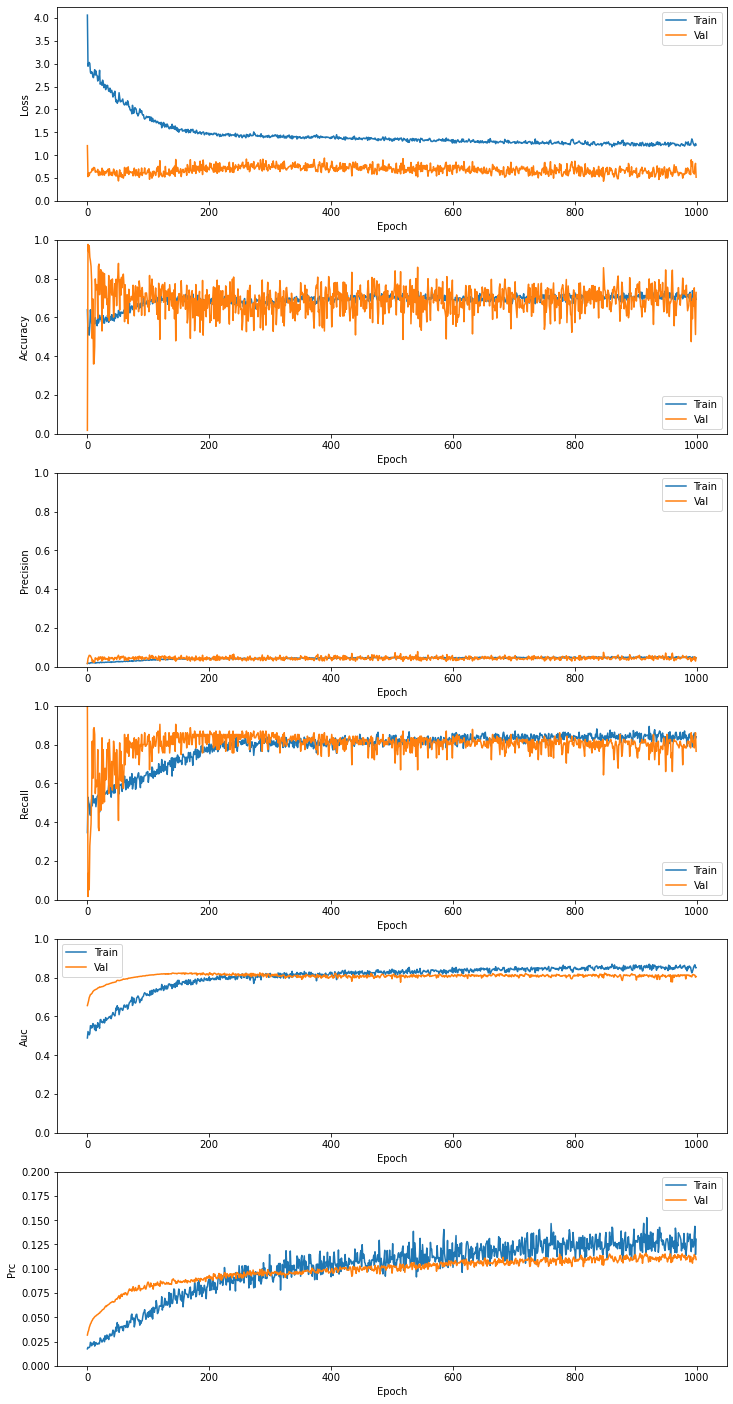

In [178]:
plot_metrics(history)

# Evaluation

In [182]:
test_predictions = model.predict(X_test_fin, batch_size=BATCH_SIZE)

In [195]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Benign Cases Detected (True Negatives): ', cm[0][0])
    print('Benign Cases Incorrectly Detected (False Positives): ', cm[0][1])
    print('Malignant Cases Missed (False Negatives): ', cm[1][0])
    print('Malignant Cases Detected (True Positives): ', cm[1][1])
    print('Total Cases: ', np.sum(cm[1]))

loss :  0.5179464817047119
tp :  88.0
fp :  1772.0
tn :  4739.0
fn :  27.0
accuracy :  0.7284938097000122
precision :  0.047311827540397644
recall :  0.7652173638343811
auc :  0.8047678470611572
prc :  0.10943245887756348

Benign Cases Detected (True Negatives):  4739
Benign Cases Incorrectly Detected (False Positives):  1772
Malignant Cases Missed (False Negatives):  27
Malignant Cases Detected (True Positives):  88
Total Cases:  115


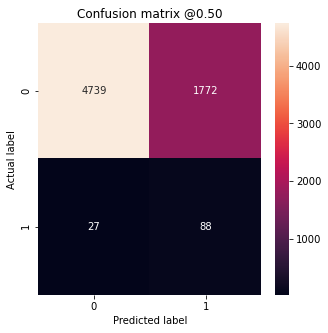

In [196]:
results = model.evaluate(X_test_fin, y_test,batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
print()

plot_cm(y_test, test_predictions)

In [193]:
model.save('/home/ubuntu/w210_melanoma/model/NN-recall:0.765-precision:0.047.hdf5')

In [194]:
test = load_model('/home/ubuntu/w210_melanoma/model/NN-recall:0.765-precision:0.047.hdf5')
test.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                32928     
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 32,945
Trainable params: 32,945
Non-trainable params: 0
_________________________________________________________________
